# Customer Churn Prediction (Classification using Deep Learning)

In [1]:
__author__ = "Jiting Jiang"
__email__ = "jiting.jiang@outlook.com"
__website__ = "https://jitingjiang.github.io/minimal-portfolio/"

## Goals

The main objective of this project is to showcase the practical application of deep learning (neural networks) using Tensorflow to predict churn in a real-world business scenario. The key aspects covered in this project include design, implementation, hyperparameter fine-tuning, model evaluation and selection.

Specifically, I completed the following tasks:
* Performed exploratory analysis and extracted insights from the dataset
* Built neural network models to predict which customers are going to churn
* Evaluated the performance of three deep learning models with varying complexity levels, including regularization techniques. 
* Tuned the regularization parameter for one of the models
* Selected the most suitable model for making churn prediction 

## Tools

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [4]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, sigmoid, linear
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

2023-07-26 22:52:57.589331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1 - Import Data and Overview

In [5]:
# Import in dataset from a csv file
churn_raw = pd.read_csv('customer_churn.csv')

churn_raw.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [6]:
churn_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

## 2 - Data Cleaning and Data Engineering

### 2.1 Check for missingness

In [7]:
# Count the number of missing values in each column and sort
missing_values = churn_raw.isnull().sum().sort_values()
missing_values

state                     0
total intl charge         0
total intl calls          0
total intl minutes        0
total night charge        0
total night calls         0
total night minutes       0
total eve charge          0
total eve calls           0
customer service calls    0
total eve minutes         0
total day calls           0
total day minutes         0
number vmail messages     0
voice mail plan           0
international plan        0
phone number              0
area code                 0
account length            0
total day charge          0
churn                     0
dtype: int64

### 2.2 Tabulate the target feature

In [8]:
churn_raw['churn'].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

In [9]:
churn_raw['churn'] = churn_raw['churn'].astype(int)

### 2.3 Transform other categorical features

In [10]:
# List all the categorical features
cat_columns = churn_raw.select_dtypes(include=['object']).columns
print(f"The list of categorical features:\n{cat_columns}")

The list of categorical features:
Index(['state', 'phone number', 'international plan', 'voice mail plan'], dtype='object')


In [11]:
# Check the distribution of these categorical features
print(f"The number of unique state: {churn_raw['state'].nunique()}")
print(f"The number of unique area code: {churn_raw['area code'].nunique()}")
print(f"The share with international plan:\n{churn_raw['international plan'].value_counts(normalize=True)}")
print(f"The share with voice mail plan:\n{churn_raw['voice mail plan'].value_counts(normalize=True)}")

The number of unique state: 51
The number of unique area code: 3
The share with international plan:
no     0.90309
yes    0.09691
Name: international plan, dtype: float64
The share with voice mail plan:
no     0.723372
yes    0.276628
Name: voice mail plan, dtype: float64


In [12]:
# One-hot encoding for 'area code', 'international plan', and 'voice mail plan'
area_dummies = pd.get_dummies(churn_raw['area code'], drop_first=True, prefix='area')
inter_dummies = pd.get_dummies(churn_raw['international plan'], drop_first=True, prefix='inter')
voice_dummies = pd.get_dummies(churn_raw['voice mail plan'], drop_first=True, prefix='voice')

### 2.4 Combine certain (closely related) features

In [13]:
churn_1 = churn_raw.copy()

churn_1['total_minutes'] = churn_1['total day minutes'] + churn_1['total eve minutes'] + churn_1['total night minutes'] + churn_1['total intl minutes']
churn_1['total_calls'] = churn_1['total day calls'] + churn_1['total eve calls'] + churn_1['total night calls'] + churn_1['total intl calls'] 
churn_1['total_charge'] = churn_1['total day charge'] + churn_1['total eve charge'] + churn_1['total night charge'] + churn_1['total intl charge'] 

### 2.5 Obtain a new dataframe

In [14]:
churn_1 = pd.concat([churn_1, area_dummies, inter_dummies, voice_dummies], axis=1)
churn_1.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total intl charge,customer service calls,churn,total_minutes,total_calls,total_charge,area_415,area_510,inter_yes,voice_yes
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,2.70,1,0,717.2,303,75.56,1,0,0,1
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,3.70,1,0,625.2,332,59.24,1,0,0,1
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,3.29,0,0,539.4,333,62.29,1,0,0,0
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,1.78,2,0,564.8,255,66.80,0,0,1,0
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,2.73,3,0,512.0,359,52.09,1,0,1,0


### 2.6 Describe all numerical features in the new dataframe

In [15]:
churn_1.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,...,total intl charge,customer service calls,churn,total_minutes,total_calls,total_charge,area_415,area_510,inter_yes,voice_yes
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,...,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,...,2.764581,1.562856,0.144914,591.864776,305.137114,59.449754,0.496550,0.252025,0.096910,0.276628
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,...,0.753773,1.315491,0.352067,89.954251,34.448164,10.502261,0.500063,0.434241,0.295879,0.447398
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,...,0.000000,0.000000,0.000000,284.300000,191.000000,22.930000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,...,2.300000,1.000000,0.000000,531.500000,282.000000,52.380000,0.000000,0.000000,0.000000,0.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,...,2.780000,1.000000,0.000000,593.600000,305.000000,59.470000,0.000000,0.000000,0.000000,0.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,...,3.270000,2.000000,0.000000,652.400000,328.000000,66.480000,1.000000,1.000000,0.000000,1.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,...,5.400000,9.000000,1.000000,885.000000,416.000000,96.150000,1.000000,1.000000,1.000000,1.000000


In [16]:
# Drop certain features
churn_1 = churn_1.drop(['total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge', 
        'state', 'area code', 'phone number', 'international plan', 'voice mail plan'], axis=1)

In [17]:
churn_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   number vmail messages   3333 non-null   int64  
 2   customer service calls  3333 non-null   int64  
 3   churn                   3333 non-null   int64  
 4   total_minutes           3333 non-null   float64
 5   total_calls             3333 non-null   int64  
 6   total_charge            3333 non-null   float64
 7   area_415                3333 non-null   uint8  
 8   area_510                3333 non-null   uint8  
 9   inter_yes               3333 non-null   uint8  
 10  voice_yes               3333 non-null   uint8  
dtypes: float64(2), int64(5), uint8(4)
memory usage: 195.4 KB


### 2.7 Visualize univariate distributions and bivariate relationships

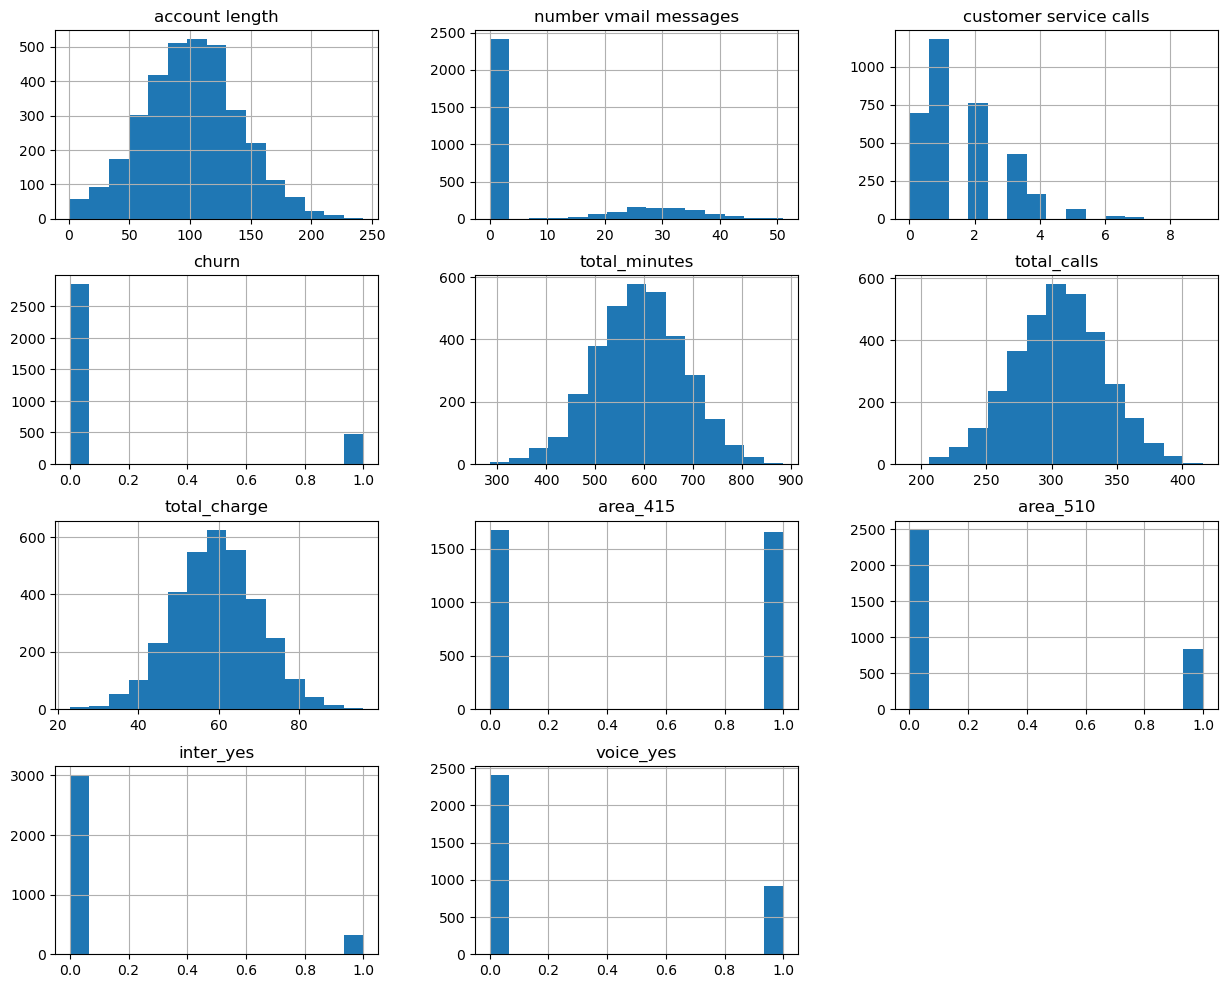

In [18]:
# Check univariate distribution of features
churn_1.hist(figsize=(15,12),bins = 15)
plt.show()

<AxesSubplot:>

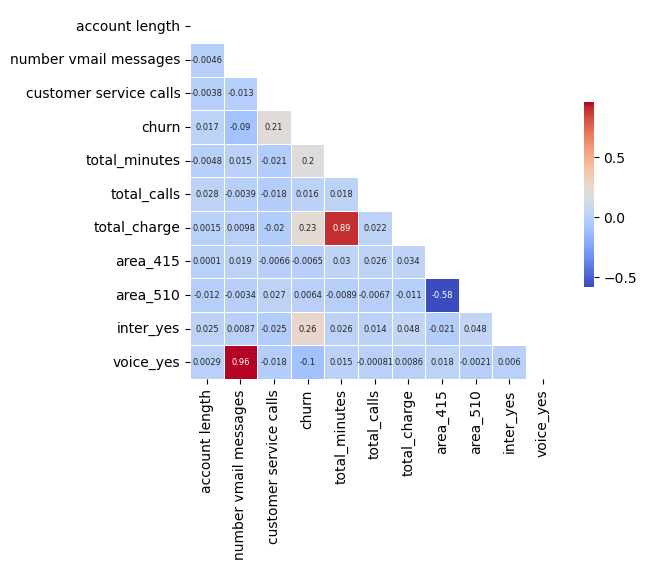

In [19]:
# Check bivariate relationship between features
corrmat = churn_1.corr(method='pearson')
corrmat.style.background_gradient()

mask = np.triu(np.ones_like(corrmat, dtype=bool))
sns.heatmap(corrmat,
            annot=True, 
            annot_kws={'fontsize': 6},
            cmap='coolwarm',
            mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:xlabel='customer service calls', ylabel='total_charge'>

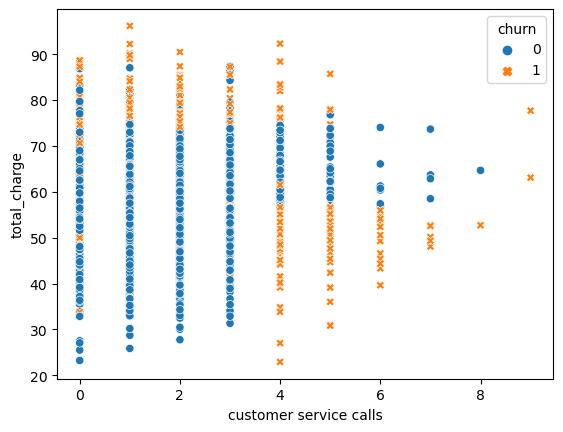

In [20]:
# Visualize two most correlated features regarding the churn target
sns.scatterplot(data=churn_1, x='customer service calls', y='total_charge', hue='churn', style='churn')

**In summary**, the cleaned dataset has 3333 records with 11 numeric features.

Upon conducting a tabulation on the target outcome, which is whether churn occurs or not, it becomes evident that the outcome is considerably skewed, with 15% representing churn and 85% indicating non-churn instances. This skewness suggests the inclusion of F1-score (precision and recall) as evaluation metrics for assessing model performance later on.

Moreover, features are shown to have quite different scales. So it is better to standardize the data to facilitate model training and prediction effectively. 

A brief visual inspection of the feature relationships, particularly with respect to the target outcome, highlights 'customer service calls' (representing the total number of customer service calls made by a customer), 'total_charge' (indicating the total amount charged to a customer during different times of the day), and 'inter_yes' (denoting whether the customer has an international plan) as the features most positively correlated with the churn outcome. A simple scatterplot confirms the idea that customers having more service calls (likely with more concerns or complaints) are more likely to churn, as well as that higher total charges also contribute to the decision for churn. 

So far, I have imported, cleaned and explored the raw data. The next step is to prepare the dataset for applying machine learning methods based on the data insights gained from the data analysis. 

## 3. Apply Deep Learning

This project involves using advanced deep learning, a subset of machine learning that uses neural networks to solve complex problems. The method is powerful for solving classification problem due to its ability to automatically learn complex and non-linear relationships from data, thus alleviating the need for extensive manual hyperparameter optimization. 

**Tensorflow**, an open-source machine learning framework developed by the Google Brain team, is applied for implementation.

The following steps are included in this section:
1. **Dataset Preparation**: The dataset is partitioned into train, cross-validation, and test sets. Additionally, feature scaling is performed to ensure a mean of 0 and a standard deviation of 1 for the features, as this step has been shown to significantly enhance model performance.

2. **Model Construction**: Three models with varying complexities are built to address the classification problem. All models compile using loss with BinaryCrossentropy and Adam optimizer with learning rate of 0.001.

    * <u>"Simple" Model</u>: This model consists of three layers: a Dense layer with 6 units and a ReLU activation, followed by another Dense layer with 6 units and ReLU activation, and finally, a Dense layer with 1 unit and a Sigmoid activation.
    
    * <u>"Complex" Model</u>: This model comprises four layers: a Dense layer with 40 units and ReLU activation, followed by a Dense layer with 20 units and ReLU activation, then a Dense layer with 6 units and ReLU activation, and finally, a Dense layer with 1 unit and a Sigmoid activation.
    
    * <u>"Complex with Regularization" Model</u>: Building on the "Complex" model, this model incorporates regularization terms to improve generalization. The regularization parameter is later fine-tuned for optimal selection.


3. **Model Evaluation**: For each model, evaluation is performed using metrics as "Accuracy," "Precision," "Recall," and "F1-score." 

4. **Model Selection**: The most suitable model is selected for this specific classification task.

### 3.1 Split and prepare the dataset

In [21]:
# Define features and target 
y = churn_1['churn']
X = churn_1.drop(['churn'], axis=1)

In [22]:
# Split into train, cross validation, and test sets
# Get 60% of the dataset as the training set.
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=42)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.50, random_state=42)

# Delete temporary variables
del X_, y_

In [23]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(1999, 10)
(667, 10)
(667, 10)
(1999,)
(667,)
(667,)


### 3.2 Scale the features

In [24]:
# Standardize the features
# Initialize the class
scaler = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

### 3.3 Build, Train, Evaluate and Select Neural Networks (using Tensorflow)

Below is the outline of the steps for applying neural networks to a classification problem after data preparation.

1. <u>Model Construction</u>:
* Build the neural network architecture by specifying the number of layers and units in each layer. 
* Define the activation function to be used in each layer. 
    * For binary classification tasks like churn prediction, the output layer could employ the sigmoid activation function. This allows the model to directly predict the probability of churn as its output.
    * ReLU activation function is suggested to use for inner layers.
* Three different models are considered: (a) Simple model, (b) Complex model, (c) Complex model with Regularization

2. <u>Model Compilation</u>:
* Compile the model using a specific loss/cost function. 
    * For binary classification problems, the appropriate loss function is BinaryCrossentropy.

3. <u>Model Training</u>:
* Train the model to minimize the chosen cost function using the training set. 
    * This process involves usingthe Adam algorithm, which adapts the learning rate based on the gradients, providing a more efficient and faster approach to minimize the cost function compared to traditional gradient descent.
    
4. <u>Model Evaluation and Selection</u>:
* Evaluate the models using metrics including Accuracy, F1-score, Precision and Recall using the cross-validation set. 
    * Accuracy is a commonly used metric for classification problems.
    * F1-score, the harmonic mean of precision and recall, is particularly valuable when dealing with imbalanced datasets, like the one in this project where churn instances are significantly fewer than non-churn instances. 
* Select the model with highest accuracy values and F1-scores
* Predict churn using test set.

In [25]:
tf.random.set_seed(42)

#### 3.3.1 Simple Model

In [26]:
# Start with a simple neural network with three layers
model_s = Sequential(
    [
        Dense(6, activation='relu', name='l1', input_dim = X.shape[1]),
        Dense(6, activation='relu', name='l2'),
        Dense(1, activation='sigmoid', name='l3')
    ], name = 'Simple'
)

In [27]:
# Compile the simple model
model_s.compile(
    loss=BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [28]:
# Train the simple model in the training set
model_s.fit(
    X_train_scaled, y_train,
    epochs=1000, verbose=0
)

In [29]:
model_s.summary()

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l1 (Dense)                  (None, 6)                 66        
                                                                 
 l2 (Dense)                  (None, 6)                 42        
                                                                 
 l3 (Dense)                  (None, 1)                 7         
                                                                 
Total params: 115 (460.00 Byte)
Trainable params: 115 (460.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
# Predict in the training and cross-validation sets
y_pred_train_s = model_s.predict(X_train_scaled)
y_pred_train_s = (y_pred_train_s > 0.5)

y_pred_cv_s = model_s.predict(X_cv_scaled)
y_pred_cv_s = (y_pred_cv_s > 0.5)

21/21 [==============================] - 0s 857us/step


In [31]:
# Evaluate the performance of the simple model in the training set
loss_train_s, accuracy_train_s, precision_train_s, recall_train_s = model_s.evaluate(X_train_scaled, y_train)
f1_train_s = f1_score(y_train, y_pred_train_s)
print(f"Training\nAccuracy:{accuracy_train_s}, \nPrecision:{precision_train_s}, \nRecall:{recall_train_s}, \nF1-score:{f1_train_s}")

63/63 [==============================] - 0s 782us/step - loss: 0.1507 - accuracy: 0.9440 - precision: 0.9487 - recall: 0.6446
Training
Accuracy:0.9439719915390015, 
Precision:0.9487179517745972, 
Recall:0.6445993185043335, 
F1-score:0.7676348547717843


In [32]:
# Evaluate the performance of the simple model in the cross-validation set
loss_cv_s, accuracy_cv_s, precision_cv_s, recall_cv_s = model_s.evaluate(X_cv_scaled, y_cv)
f1_cv_s = f1_score(y_cv, y_pred_cv_s)
print(f"CV\nAccuracy:{accuracy_cv_s}, \nPrecision:{precision_cv_s}, \nRecall:{recall_cv_s}, \nF1-score:{f1_cv_s}")

21/21 [==============================] - 0s 1ms/step - loss: 0.2417 - accuracy: 0.9220 - precision: 0.8529 - recall: 0.5800
CV
Accuracy:0.9220389723777771, 
Precision:0.8529411554336548, 
Recall:0.5799999833106995, 
F1-score:0.6904761904761905


#### 3.3.2 Complex model 

In [33]:
# Compare with a more complex model
model_c = Sequential(
    [
        Dense(40, activation='relu', name='l1', input_dim = X.shape[1]),
        Dense(20, activation='relu', name='l2'),
        Dense(6, activation='relu', name='l3'),
        Dense(1, activation='sigmoid', name='l4')
    ], name = 'Complex'
)

In [34]:
# Compile the complex model
model_c.compile(
    loss=BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [35]:
# Train the complex model in the training set
model_c.fit(
    X_train_scaled, y_train,
    epochs=1000, verbose=0
)

In [36]:
# Predict the complex model in the training and cv sets
y_pred_train_c = model_c.predict(X_train_scaled)
y_pred_train_c = (y_pred_train_c > 0.5)

y_pred_cv_c = model_c.predict(X_cv_scaled)
y_pred_cv_c = (y_pred_cv_c > 0.5)

21/21 [==============================] - 0s 823us/step


In [37]:
# Evaluate the performance of the complex model in training set 
loss_train_c, accuracy_train_c, precision_train_c, recall_train_c = model_c.evaluate(X_train_scaled, y_train)
f1_train_c = f1_score(y_train, y_pred_train_c)
print(f"Training\nAccuracy:{accuracy_train_c}, \nPrecision:{precision_train_c}, \nRecall:{recall_train_c}, \nF1-score:{f1_train_c}")

63/63 [==============================] - 0s 831us/step - loss: 0.0046 - accuracy: 0.9990 - precision_1: 0.9931 - recall_1: 1.0000
Training
Accuracy:0.9989994764328003, 
Precision:0.9930796027183533, 
Recall:1.0, 
F1-score:0.9965277777777778


In [38]:
# Evaluate the performance of the complex model in cv set 
loss_cv_c, accuracy_cv_c, precision_cv_c, recall_cv_c = model_c.evaluate(X_cv_scaled, y_cv)
f1_cv_c = f1_score(y_cv, y_pred_cv_c)
print(f"CV\nAccuracy:{accuracy_cv_c}, \nPrecision:{precision_cv_c}, \nRecall:{recall_cv_c}, \nF1-score:{f1_cv_c}")

21/21 [==============================] - 0s 965us/step - loss: 1.5337 - accuracy: 0.9055 - precision_1: 0.7229 - recall_1: 0.6000
CV
Accuracy:0.9055472016334534, 
Precision:0.7228915691375732, 
Recall:0.6000000238418579, 
F1-score:0.6557377049180328


#### 3.3.3 Complex model with Regularization

In [39]:
# Consider the complex model with regularization
model_r = Sequential(
    [
        Dense(40, activation='relu', name='l1', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_dim = X.shape[1]),
        Dense(20, activation='relu', name='l2', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dense(6, activation='relu', name='l3', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dense(1, activation='sigmoid', name='l4')
    ], name = 'Cregularization'
)

In [40]:
# Compile the regularization model
model_r.compile(
    loss=BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [41]:
# Train the regularization model in the training set
model_r.fit(
    X_train_scaled, y_train,
    epochs=1000, verbose=0
)

In [42]:
# Predict the regularization model in the training and cv sets
y_pred_train_r = model_r.predict(X_train_scaled)
y_pred_train_r = (y_pred_train_r > 0.5)

y_pred_cv_r = model_r.predict(X_cv_scaled)
y_pred_cv_r = (y_pred_cv_r > 0.5)

21/21 [==============================] - 0s 925us/step


In [43]:
# Evaluate the performance of the regularization model in the training set
loss_train_r, accuracy_train_r, precision_train_r, recall_train_r = model_r.evaluate(X_train_scaled, y_train)
f1_train_r = f1_score(y_train, y_pred_train_r)
print(f"Training\nAccuracy:{accuracy_train_r}, \nPrecision:{precision_train_r}, \nRecall:{recall_train_r}, \nF1-score:{f1_train_r}")

63/63 [==============================] - 0s 829us/step - loss: 0.1869 - accuracy: 0.9530 - precision_2: 0.9327 - recall_2: 0.7247
Training
Accuracy:0.9529764652252197, 
Precision:0.9327354431152344, 
Recall:0.7247386574745178, 
F1-score:0.8156862745098039


In [44]:
# Evaluate the performance of the regularization model in the cv set
loss_cv_r, accuracy_cv_r, precision_cv_r, recall_cv_r = model_r.evaluate(X_cv_scaled, y_cv)
f1_cv_r = f1_score(y_cv, y_pred_cv_r)
print(f"CV\nAccuracy:{accuracy_cv_r}, \nPrecision:{precision_cv_r}, \nRecall:{recall_cv_r}, \nF1-score:{f1_cv_r}")

21/21 [==============================] - 0s 1ms/step - loss: 0.2396 - accuracy: 0.9295 - precision_2: 0.8442 - recall_2: 0.6500
CV
Accuracy:0.9295352101325989, 
Precision:0.8441558480262756, 
Recall:0.6499999761581421, 
F1-score:0.7344632768361582


#### 3.3.4 Iterate to find optimal regularization value

In [45]:
# A list of regularization parameter values
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]

In [46]:
# Loop over different models
models = [None]*len(lambdas)

for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] = Sequential(
        [
            Dense(40, activation='relu', name='l1', kernel_regularizer=tf.keras.regularizers.l2(lambda_), input_dim = X.shape[1]),
            Dense(20, activation='relu', name='l2', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(6, activation='relu', name='l3', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(1, activation='sigmoid', name='l4')   
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics = ['accuracy']
    )
    models[i].fit(
        X_train_scaled, y_train,
        epochs=1000, verbose=0
    )
    print(f"Finished lambda = {lambda_}")

Finished lambda = 0.0
Finished lambda = 0.001
Finished lambda = 0.01
Finished lambda = 0.05
Finished lambda = 0.1
Finished lambda = 0.2
Finished lambda = 0.3


21/21 [==============================] - 0s 911us/step - loss: 0.4227 - accuracy: 0.8501


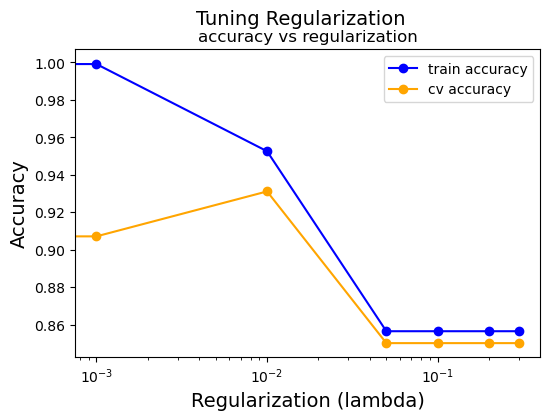

In [47]:
# Define and Plot accuracy over regularization parameter values
def plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv):
    loss_train = np.zeros(len(lambdas))
    loss_cv = np.zeros(len(lambdas))
    err_train = np.zeros(len(lambdas))
    err_cv = np.zeros(len(lambdas))
    for i in range(len(models)):
        loss_train[i], err_train[i] = models[i].evaluate(X_train, y_train)
        loss_cv[i], err_cv[i] = models[i].evaluate(X_cv, y_cv)

    fig, ax = plt.subplots(1,1,figsize=(6,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax.set_title("accuracy vs regularization",fontsize = 12)
    ax.plot(lambdas, err_train, marker='o', label="train accuracy", color = 'blue')
    ax.plot(lambdas, err_cv,    marker='o', label="cv accuracy",    color = 'orange')
    ax.set_xscale('log')
    ax.set_ylim(*ax.get_ylim())
    ax.set_xlabel("Regularization (lambda)",fontsize = 14)
    ax.set_ylabel("Accuracy",fontsize = 14)
    ax.legend()
    fig.suptitle("Tuning Regularization",fontsize = 14)
    plt.show()
    
plot_iterate(lambdas, models, X_train_scaled, y_train, X_cv_scaled, y_cv)

From the visualization, it becomes evident that a preferred regularization parameter value is 0.01 for the complex model, achieving the highest accuracy (as indicated by the yellow line).

When using smaller lambda values, it is possible to achieve almost perfect accuracy on the training set. However, the model struggles to maintain this level of accuracy on the cross-validation set, suggesting an overfitting problem. This situation is characterized by lower bias but higher variance, where the model becomes too complex and specific to the training data, making it challenging to generalize well to new data.

On the other hand, when using larger lambda values, the model's performance in both the training and cross-validation sets deteriorates rapidly, resulting in significantly worse performance. This occurs as the large regularization penalty imposes strong constraints on the model's complexity, leading to an overly simplistic model that fails to capture the underlying patterns in the data.

#### 3.3.5 Select model

In [48]:
print("accuracy:", "{:.2f}".format(accuracy_train_s), "f1-score:", "{:.2f}".format(f1_train_s), "precision:", "{:.2f}".format(precision_train_s), "recall:","{:.2f}".format(recall_train_s),"Model:", "Simple, Training")
print("accuracy:", "{:.2f}".format(accuracy_cv_s), "f1-score:", "{:.2f}".format(f1_cv_s), "precision:", "{:.2f}".format(precision_cv_s), "recall:","{:.2f}".format(recall_cv_s),"Model:", "Simple, CV")

print("accuracy:", "{:.2f}".format(accuracy_train_c), "f1-score:", "{:.2f}".format(f1_train_c), "precision:", "{:.2f}".format(precision_train_c), "recall:","{:.2f}".format(recall_train_c),"Model:", "Complex, Training")
print("accuracy:", "{:.2f}".format(accuracy_cv_c), "f1-score:", "{:.2f}".format(f1_cv_c), "precision:", "{:.2f}".format(precision_cv_c), "recall:","{:.2f}".format(recall_cv_c),"Model:", "Complex, CV")

print("accuracy:", "{:.2f}".format(accuracy_train_r), "f1-score:", "{:.2f}".format(f1_train_r), "precision:", "{:.2f}".format(precision_train_r), "recall:","{:.2f}".format(recall_train_r),"Model:", "Regularization, Training")
print("accuracy:", "{:.2f}".format(accuracy_cv_r), "f1-score:", "{:.2f}".format(f1_cv_r), "precision:", "{:.2f}".format(precision_cv_r), "recall:","{:.2f}".format(recall_cv_r),"Model:", "Regularization, CV")

accuracy: 0.94 f1-score: 0.77 precision: 0.95 recall: 0.64 Model: Simple, Training
accuracy: 0.92 f1-score: 0.69 precision: 0.85 recall: 0.58 Model: Simple, CV
accuracy: 1.00 f1-score: 1.00 precision: 0.99 recall: 1.00 Model: Complex, Training
accuracy: 0.91 f1-score: 0.66 precision: 0.72 recall: 0.60 Model: Complex, CV
accuracy: 0.95 f1-score: 0.82 precision: 0.93 recall: 0.72 Model: Regularization, Training
accuracy: 0.93 f1-score: 0.73 precision: 0.84 recall: 0.65 Model: Regularization, CV


Based on the evaluation results of the three models, the following observations can be made:

* <u>Complex Model vs. Complex with Regularization Model</u>: The "Complex with regularization" model outperforms the "Complex" model on the cross-validation set across all the examined metrics. This discrepancy suggests a potential overfitting issue with the "Complex" model. 

* <u>Simple Model vs. Complex with Regularization Model</u>: Both the "Simple" model and the "Complex with regularization" model output similar accuracy (92%) and precision (85%) on the cross-validation set. However, the "Complex with Regularization" model has significantly higher F1-score (73% compared to 69%) and recall (65% compared to 58%). 

So I would prefer the "Complex with Regularization" model, whose prediction results using the test set are shown below. The final model achieves fine performance, with an accuracy of 0.93 and an F1-score of 0.73 on the test set. 

In [51]:
# Predict in the test set using the Simple model
y_pred_test_r = model_r.predict(X_test_scaled)
y_pred_test_r = (y_pred_test_r > 0.5)

21/21 [==============================] - 0s 775us/step


In [52]:
# Evaluate the performance of the simple model in the test set
loss_test_r, accuracy_test_r, precision_test_r, recall_test_r = model_r.evaluate(X_test_scaled, y_test)
f1_test_r = f1_score(y_test, y_pred_test_r)
print(f"Test\nAccuracy:{accuracy_test_r}, \nPrecision:{precision_test_r}, \nRecall:{recall_test_r}, \nF1-score:{f1_test_r}")

21/21 [==============================] - 0s 1ms/step - loss: 0.2262 - accuracy: 0.9340 - precision_2: 0.8824 - recall_2: 0.6250
Test
Accuracy:0.9340329766273499, 
Precision:0.8823529481887817, 
Recall:0.625, 
F1-score:0.7317073170731708


### Conclusion

This project implemented neural network models for a classification problem predicting customer churn. 

As noted, the relatively low F1-score associalted with final the model highlights the need for further model improvement, particularly to enhance recall and capture more actual churn instances. To achieve this, strategies such as adjusting the decision threshold, gathering additional relevant data, exploring different model architectures, or using different sampling techniques can be considered to enhance the recall while maintaining a reasonable level of precision.